# AprilTag Minimal Working Example with Dedicated Hardware 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AccelerationConsortium/ac-training-lab/blob/main/src/ac_training_lab/apriltag_hardware_demo/apriltag_hardware_demo.ipynb)


## Introduction 

### What this system does

This system uses a rotating turntable, AprilTag visual markers, and a MyCobot robotic arm to identify, localize, and manipulate vials. The robot can automatically pick up or place vials at specified positions on the turntable.

### Why AprilTags are used

AprilTags provide robust and accurate visual markers that enable the system to detect specific positions on the turntable. Since tags are attached to the turntable (not the vials), they help determine the vial’s location indirectly through a mapping. This allows the system to precisely stop the turntable at the right spot for pick-and-place operations.

### How the workflow proceeds in steps
1. After startup, the turntable rotates slowly.
2. A fixed camera captures frames continuously to detect AprilTags.
3. When the target tag is found, the turntable stops and the corresponding vial is aligned for interaction.
4. The tag’s position is recalculated and converted into robot coordinates using a pre-calibrated transformation matrix.
5. The robot arm grabs or places the vial from the side.

## Configuration

To explore the demo with default files and settings, enable test mode below. If test mode is enabled, you can skip all parameter modifications in this demo.

In [1]:
# @markdown Set `test = True` to use default files and parameters.
test = True  # @param {type:"boolean"}

## Requirements

This notebook requires the following files and libraries. 

In [ ]:
# only install if we are running in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    %pip install opencv-python-headless pupil-apriltags scipy matplotlib pillow gradio_client

## Live Stream

##### Watch the live demo here: https://www.youtube.com/playlist?list=PL8uZlc2CEpelrYXunUzUOMJC17wEhiP6Q

This live stream shows the dedicated hardware in action, giving you a real-time view of what’s happening in the lab.
You’ll see the AprilTags, turntable, and cobot working together to complete the workflow.
As you run the notebook, each step is mirrored by real-world motion.

> Tips: For a smoother experience, use Picture-in-Picture mode to keep the live stream visible while interacting with the notebook (right-click the video twice in Google Chrome or Microsoft Edge), or consider using split screen to view the notebook and stream side by side.


## Static configuration

Predefined system parameters, determined by the hardware setup and relative positioning.

#### **⚠ Do not modify any of them.**


### Tracking vials in turntable
To track each specific vial and its current position, as well as whether a turntable position is occupied, we maintain two bidirectional mappings in the program:

- Turntable ID ↔ AprilTag ID
- Turntable ID ↔ Vial ID

This allows the program to identify the corresponding AprilTag and vial for each position, so users can assign a specific vial to a specific slot.

> Note:  You can refer to the livestream to visually confirm the mapping. The key in the vial_to_turntable dictionary is the vial ID, and the value is the turntable position ID.


In [3]:
# Static configuration
# Only positions currently occupied by vials
vial_to_turntable = {
    'vial_1': 3, # vial_1 is currently placed at turntable position 3
    'vial_2': 1,
    'vial_3': 5,
}

# All turntable positions and their associated AprilTags
turntable_to_tag = {
    1: 'tag_01', # turntable position 1 is labeled by tag_01
    2: 'tag_02',
    3: 'tag_03',
    4: 'tag_04',
    5: 'tag_05',
    6: 'tag_06',
    7: 'tag_07',
    8: 'tag_08',
    
}

# Generate reverse mappings
tag_to_turntable = {v: k for k, v in turntable_to_tag.items()}
turntable_to_vial = {v: k for k, v in vial_to_turntable.items()}

### Camera Intrinsics

Camera intrinsics obtained from camera calibration, including camera matrix and distortion coefficients. Used for AprilTag detection and pose estimation.

In [1]:
# @title Load Camera Calibration (DO NOT MODIFY)
import os
import numpy as np
import urllib.request

current_dir = os.getcwd()
camera_params_path = os.path.join(current_dir, "camera_params.npy")

# NOTE: change the branch from apriltag_cobot_example to main after merged, then remove this comment
camera_params_url = "https://github.com/AccelerationConsortium/ac-training-lab/raw/apriltag_cobot_example/src/ac_training_lab/apriltag_hardware_demo/camera_params.npy"
urllib.request.urlretrieve(camera_params_url, camera_params_path)

camera_params = np.load(camera_params_path, allow_pickle=True).item()

K = camera_params["camera_matrix"]
dist = camera_params["dist_coeff"]

camera_intrinsics = (K, dist)
print(camera_intrinsics)


(array([[499.92512635,   0.        , 323.42607618],
       [  0.        , 499.55737903, 234.74922485],
       [  0.        ,   0.        ,   1.        ]]), array([[ 5.71859199e-02, -2.10294593e-02,  5.02016000e-05,
         1.92702749e-03, -1.58506523e-01]]))



### Hand-Eye Calibration Result

Camera intrinsics obtained from camera calibration, including camera matrix and distortion coefficients. Used for predicting vial positions and performing grasping.

In [2]:
# @title Load Hand-Eye Calibration (DO NOT MODIFY)
import os
import numpy as np

# Assume current working directory is apriltag_hardware_demo
current_dir = os.getcwd()
hand_eye_path = os.path.join(current_dir, "hand_eye_calibration.npy")

# NOTE: change the branch from apriltag_cobot_example to main after merged, then remove this comment
hand_eye_url = "https://github.com/AccelerationConsortium/ac-training-lab/raw/apriltag_cobot_example/src/ac_training_lab/apriltag_hardware_demo/hand_eye_calibration.npy"
urllib.request.urlretrieve(hand_eye_url, hand_eye_path)

hand_eye_params = np.load(hand_eye_path, allow_pickle=True).item()
rotation_matrix = hand_eye_params["rotation_matrix"]
translation_vector = hand_eye_params["translation_vector"].flatten() * 1000

hand_eye_calibration = (rotation_matrix, translation_vector)

print(hand_eye_calibration)
from scipy.spatial.transform import Rotation as R
r = R.from_matrix(rotation_matrix)
print("rotation_matrix (deg):", r.as_euler('xyz', degrees=True))

(array([[ 7.26773708e-01, -6.86864149e-01,  4.19732523e-03],
       [ 6.86849838e-01,  7.26785745e-01,  4.44769560e-03],
       [-6.10551880e-03, -3.49536076e-04,  9.99981300e-01]]), array([-26.98554173, -32.67126233,   2.5577673 ]))
rotation_matrix (deg): [-2.00273157e-02  3.49822632e-01  4.33822699e+01]


### Default Positions

- **INITIAL_HOME_POSE**: Moves the cobot to all-zero joint angles as the home or reset position.
- **DEFAULT_DETECTION_POSE**: Moves the cobot to a pre-defined joint configuration for AprilTag detection.

In [ ]:
# @title Default Detection Pose and Initial Home Pose Configuration (DO NOT MODIFY)

INITIAL_HOME_POSE = {
    "angle0": 0,
    "angle1": 0,
    "angle2": 0,
    "angle3": 0,
    "angle4": 0,
    "angle5": 0,
    "movement_speed": 50
}

DEFAULT_DETECTION_POSE = {
    "angle0": -72.94,
    "angle1": 37.7,
    "angle2": 127.17,
    "angle3": -137.81,
    "angle4": 96.06,
    "angle5": -17.57,
    "movement_speed": 50
}


### Grasp Offset Configuration

Defines the fixed offsets between the cobot end-effector and the vial center, specified in the AprilTag coordinate frame.

- **GRIPPER_TOTAL_OFFSET**: Offset used during pick-up.
- **GRIPPER_TOTAL_OFFSET_PLACEMENT**: Slightly adjusted offset used for placement.
- **GRASP_FIX**: Cconstant angular offset between the gripper’s actual orientation and the nominal end-effector frame.

In [ ]:
# @title Grasp Offset Configuration (DO NOT MODIFY)

GRIPPER_TOTAL_OFFSET = np.array([0.0, -35.0, -80.0])  # in mm

GRIPPER_TOTAL_OFFSET_PLACEMENT = np.array([0.0, -35.0, -78.0])  # in mm

GRASP_FIX = [0.0, 0.0, 0.0] # in rad

## Helper functions

### `detect_apriltags`
This is a helper function for detecting AprilTags.
- When `only_ID=True`, it returns only the tag IDs, which is useful for identifying the correct AprilTag while the turntable is rotating.
- When `only_ID=False`, it returns both the position and orientation of each tag, which is used by the cobot to place or pick up a vial after the turntable has stopped.

In [5]:
import cv2
import numpy as np
from pupil_apriltags import Detector
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

def detect_apriltags(image_path, camera_matrix, dist_coeffs, tag_size_meters, families="tagStandard41h12", only_ID=True, show_image=False):
    """
    AprilTag detection function with built-in undistortion.
    """
    # Load grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}")

    # Undistort image first
    undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs)

    # Extract fx, fy, cx, cy for pupil_apriltags input
    fx, fy = camera_matrix[0,0], camera_matrix[1,1]
    cx, cy = camera_matrix[0,2], camera_matrix[1,2]
    pupil_camera_params = [fx, fy, cx, cy]

    # Initialize detector
    at_detector = Detector(
        families=families,
        nthreads=1,
        quad_decimate=1.0,
        quad_sigma=0.0,
        refine_edges=1,
        decode_sharpening=0.25,
        debug=0
    )

    detections = at_detector.detect(
        undistorted_image,
        estimate_tag_pose=True,
        camera_params=pupil_camera_params,
        tag_size=tag_size_meters
    )

    if only_ID:
        return [det.tag_id for det in detections]

    print(f"Found {len(detections)} tags")
    for det in detections:
        tag_id = det.tag_id
        center = det.center
        corners = det.corners.astype(int)

        cv2.polylines(undistorted_image, [corners], True, 255, 2)
        cx, cy = map(int, center)
        cv2.circle(undistorted_image, (cx, cy), 4, 255, -1)
        cv2.putText(undistorted_image, str(tag_id), (cx, cy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255, 1)

        print(f"\nTag ID: {tag_id}")
        print(f"  Center: {center}")
        print(f"  Corners: {det.corners}")

        if det.pose_t is not None:
            t = det.pose_t.flatten()
            print(f"  Translation (x, y, z): {t}")

            distance_cm = np.linalg.norm(t) * 100
            print(f"  Distance from camera: {distance_cm:.2f} centimeters")

            euler = R.from_matrix(det.pose_R).as_euler('xyz', degrees=True)
            roll, pitch, yaw = euler
            print(f"  Roll: {roll:.2f}°, Pitch: {pitch:.2f}°, Yaw: {yaw:.2f}°")
        else:
            print("  No pose estimated (pose_t is None)")

    if show_image:
        plt.imshow(undistorted_image, cmap='gray')
        plt.title("AprilTag Detection (Undistorted)")
        plt.show()

    return detections



### `display_image` and `display_result`

- `display_image(image_path)`: Displays the image at the given path (used to check camera view or results).
- `display_result(result)`: Parses and prints server response, shows queue status and detection results, and displays image if available.

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import json

def display_image(image_path):
	try:
		img = Image.open(image_path).convert("RGB")
		plt.imshow(img)
		plt.title("Cobot view")
		plt.show()
	except Exception as e:
		print(f"An error occurred: {e}")

def display_result(result):
	queue_status_str = result[-1].replace('\n', ' ')
	print(f"queue status: {queue_status_str}")
	print(f"response json: {None if result[0] is None else json.loads(result[0])}")
	if len(result) == 3:
		if result[1] is None:
			return
		display_image(result[1]['value'])

### `decompose_transform` and `convert`

- `decompose_transform(matrix)`: Decomposes a 4x4 homogeneous transformation matrix into translation and Euler angles (rx, ry, rz). Used to extract position and orientation from computed poses.
- `convert(x, y, z, rx, ry, rz, x1, y1, z1, rx1, ry1, rz1, hand_eye_calibration)`: Computes the object pose in the robot base frame by chaining the robot's end-effector pose, the detected object pose from camera, and the hand-eye calibration result.

In [ ]:
from scipy.spatial.transform import Rotation as R
import numpy as np


def decompose_transform(matrix):

    translation = matrix[:3, 3]
    rotation = matrix[:3, :3]

    # Convert rotation matrix to euler angles (rx, ry, rz)
    sy = np.sqrt(rotation[0, 0] * rotation[0, 0] + rotation[1, 0] * rotation[1, 0])
    singular = sy < 1e-6

    if not singular:
        rx = np.arctan2(rotation[2, 1], rotation[2, 2])
        ry = np.arctan2(-rotation[2, 0], sy)
        rz = np.arctan2(rotation[1, 0], rotation[0, 0])
    else:
        rx = np.arctan2(-rotation[1, 2], rotation[1, 1])
        ry = np.arctan2(-rotation[2, 0], sy)
        rz = 0

    return translation, rx, ry, rz

def convert(x, y, z, rx, ry, rz, x1, y1, z1, rx1, ry1, rz1):
    
    end_effector_pose = np.array([x, y, z, rx, ry, rz])
    
    T_camera_to_end = np.eye(4)
    T_camera_to_end[:3, :3] = rotation_matrix
    T_camera_to_end[:3, 3] = translation_vector
    
    T_base_to_end = np.eye(4)
    T_base_to_end[:3, :3] = R.from_euler('xyz', end_effector_pose[3:], degrees=False).as_matrix()
    T_base_to_end[:3, 3] = end_effector_pose[:3]

    tag_position = np.array([x1, y1, z1])
    tag_rotation = R.from_euler('xyz', [rx1, ry1, rz1], degrees=False).as_matrix()
    
    T_obj_to_cam = np.eye(4)
    T_obj_to_cam[:3, :3] = tag_rotation      
    T_obj_to_cam[:3, 3] = tag_position
    
    T_obj_to_end = T_camera_to_end @ T_obj_to_cam
    T_obj_to_base = T_base_to_end @ T_obj_to_end
    
    position = T_obj_to_base[:3, 3]  
    grasp_fix = R.from_euler('xyz', GRASP_FIX, degrees=False)
    final_rotation = R.from_matrix(T_obj_to_base[:3, :3]) * grasp_fix
    grasp_rx, grasp_ry, grasp_rz = final_rotation.as_euler('xyz', degrees=False)
    
    return position, grasp_rx, grasp_ry, grasp_rz



### `move_to_pose`

- Used to move the robot directly to the computed grasping position.

In [8]:
def move_to_pose(result_pose, movement_speed=50):
    position, rx, ry, rz = result_pose

    x_mm, y_mm, z_mm = [round(float(val), 2) for val in position]
    roll_deg = round(np.degrees(rx), 2)
    pitch_deg = round(np.degrees(ry), 2)
    yaw_deg = round(np.degrees(rz), 2)

    print("Sending coords (mm, deg):", x_mm, y_mm, z_mm, roll_deg, pitch_deg, yaw_deg)

    result = client.predict(
        user_id=USER_ID,
        x=x_mm,
        y=y_mm,
        z=z_mm,
        roll=-90,
        pitch=pitch_deg,
        yaw=-64,
        movement_speed=movement_speed,
        api_name="/control_coords"
    )
    display_result(result)



## Connecting to the Cobot

### Initialize Gradio Client

- Create a unique `USER_ID` for the current session.
- Connect to the remote Gradio server (`cobot280pi-gradio-g9sv`) using Hugging Face token.
- `client.view_api()` lists available API endpoints for interaction.

In [11]:
from gradio_client import Client
import uuid
import getpass  

USER_ID = str(uuid.uuid4())
print(f"Your user id: {USER_ID}")

hf_token = getpass.getpass("Enter your Hugging Face Token:")

client = Client(
    "AccelerationConsortium/cobot280pi-gradio-g9sv",
    hf_token=hf_token
)

client.view_api()

result = client.predict(
    user_id=USER_ID,
    api_name="/enter_queue"
)

print(result)


Your user id: 25a4c873-5cf9-49af-88ec-2404c9f11096
Loaded as API: https://accelerationconsortium-cobot280pi-gradio-g9sv.hf.space ✔
Client.predict() Usage Info
---------------------------
Named API endpoints: 15

 - predict(user_id, api_name="/query_angles") -> (response, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  
    Returns:
     - [Textbox] response: str 
     - [Textbox] queue_status: str 

 - predict(user_id, api_name="/query_coords") -> (response, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  
    Returns:
     - [Textbox] response: str 
     - [Textbox] queue_status: str 

 - predict(user_id, api_name="/query_gripper") -> (response, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  
    Returns:
     - [Textbox] response: str 
     - [Textbox] queue_status: str 

 - predict(user_id, api_name="/query_camera") -> (response, value_72, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  

### Enter Queue

- Call `/enter_queue` API to join the task queue.
- The server assigns a queue position and returns status info.

In [12]:
result = client.predict(
    user_id=USER_ID,
    api_name="/enter_queue"
)

print(result)

Your turn!
Time remaining: 113.34 seconds.


## Cobot Vial Pick-and-Place Workflow

First, move the cobot to the default place to detect apriltag

In [185]:
result = client.predict(
    user_id=USER_ID,
    **DEFAULT_DETECTION_POSE, 
    api_name="/control_angles"
)
display_result(result)

queue status: Your turn! Time remaining: 120.00 seconds.
response json: {'success': True, 'command': 'control/angles'}


Then detect the AprilTag. If no tag is detected, retry several times.

('{\n    "success": true,\n    "command": "query/camera"\n}', {'visible': True, 'value': 'C:\\Users\\86173\\AppData\\Local\\Temp\\gradio\\fc164bd887a4cc6074035705b07a31440744aeaad084ce43aaf391e5d9ec8330\\image.webp', '__type__': 'update'}, 'Your turn!\nTime remaining: 108.19 seconds.')
queue status: Your turn! Time remaining: 108.19 seconds.
response json: {'success': True, 'command': 'query/camera'}


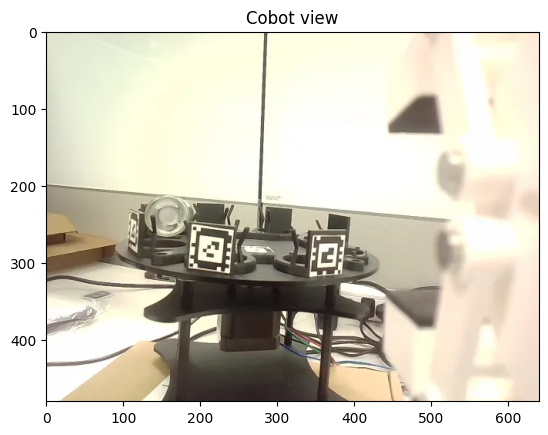

Found 2 tags

Tag ID: 2
  Center: [197.07231037 213.90559042]
  Corners: [[183.55516052 197.04176331]
 [178.87197876 228.04412842]
 [210.94502258 231.2130127 ]
 [215.33161926 199.72123718]]
  Translation (x, y, z): [-0.05087189 -0.00840278  0.20144006]
  Distance from camera: 20.79 centimeters
  Roll: 1.68°, Pitch: 10.62°, Yaw: 95.54°

Tag ID: 3
  Center: [189.60523444 364.77744253]
  Corners: [[173.58430481 351.05438232]
 [175.27854919 374.9571228 ]
 [205.11898804 378.06607056]
 [204.46142578 354.2215271 ]]
  Translation (x, y, z): [-0.05674382  0.05516048  0.21199041]
  Distance from camera: 22.63 centimeters
  Roll: 1.16°, Pitch: -26.18°, Yaw: 95.10°


In [186]:
result = client.predict(
	user_id=USER_ID,
	api_name="/query_camera"
)
print(result)
display_result(result)
image_path = result[1]["value"]

import numpy as np

camera_params = np.load("camera_params.npy", allow_pickle=True).item()

detections = detect_apriltags(
    image_path,
    camera_matrix=camera_params['camera_matrix'],
    dist_coeffs=camera_params['dist_coeff'],
    tag_size_meters=0.013,
    families="tagStandard52h13",
    only_ID=False
)


Compute the gripper’s corrected pose by applying a predefined offset to the AprilTag detection and transforming it to world coordinates for motion planning.

In [ ]:
det = min(detections, key=lambda d: np.linalg.norm(d.pose_t))

pose_t = det.pose_t.flatten()         
pose_R = det.pose_R                  

offset_in_world = pose_R @ (GRIPPER_TOTAL_OFFSET / 1000.0)  
pose_t_corrected = pose_t + offset_in_world               
pose_t_corrected_mm = pose_t_corrected * 1000             

rx1, ry1, rz1 = R.from_matrix(pose_R).as_euler('xyz', degrees=False)  

x1, y1, z1 = pose_t_corrected_mm

print("Corrected position for gripper (mm):", pose_t_corrected_mm)
print("Euler angles (radians):", rx1, ry1, rz1)
print("Tag Z axis in camera frame:", pose_R[:, 2])

Corrected position for gripper (mm): [-16.95032056 -20.10535744 121.83241258]
Euler angles (radians): 0.029397501484402126 0.18530117345465325 1.6674830540025343
Tag Z axis in camera frame: [0.0114776  0.18614033 0.98245613]


In [ ]:
# TODO: Implement turntable logic to rotate the turntable to the target position and grasp the specific vial.

Query the current coordinates from the cobot, then compute the object's pose in the robot base frame using the end-effector pose, AprilTag detection, and hand-eye calibration.

If querying fails or the coordinates seem outdated, try running the cell a few more times — the cobot may return stale data due to latency.

As a reference, check if the returned coordinates are close to:

```
[-55.2, 120.6, 198.0, -93.67, -44.2, -65.47]
```

These represent a known pose near the AprilTag. If the result deviates significantly, retry until a stable reading is returned.


In [197]:
result = client.predict(
    user_id=USER_ID,
    api_name="/query_coords"
)
display_result(result)


queue status: Your turn! Time remaining: 47.71 seconds.
response json: {'success': True, 'coords': [-55.9, 122.3, 194.7, -94.31, -45.82, -64.55], 'command': 'query/coords'}


Compute robot base frame

In [202]:
import json
import numpy as np

result_json = json.loads(result[0])
coords = result_json["coords"]  
x, y, z, rx, ry, rz = coords 

rx_rad = np.radians(rx)
ry_rad = np.radians(ry)
rz_rad = np.radians(rz)

result_pose = convert(
    x, y, z,                  
    rx_rad, ry_rad, rz_rad, 
    x1, y1, z1,               
    rx1, ry1, rz1             
)

position, rx_base, ry_base, rz_base = result_pose

print("Target pose in robot base frame:")
print("Position:", position)
print("Rotation (Euler angles in rad):", rx_base, ry_base, rz_base)

Target pose in robot base frame:
Position: [ 37.6207729  224.89738607 210.8359296 ]
Rotation (Euler angles in rad): -1.6436987473725357 0.7683419613227258 -1.2313159753166025


Open gripper

In [125]:
result = client.predict(
	user_id=USER_ID,
	gripper_value = 100,
	movement_speed = 100,
	api_name="/control_gripper"
)
display_result(result)

queue status: Your turn! Time remaining: 72.50 seconds.
response json: {'success': True, 'command': 'control/gripper'}


Move to the position above the vial, ready to perform the pick-up.

In [208]:
position, rx_base, ry_base, rz_base = result_pose
x, y, z = position

z_above = z + 70

above_pose = ((x, y, z_above), rx_base, ry_base, rz_base)
move_to_pose(above_pose)


Sending coords (mm, deg): 37.62 224.9 280.84 -94.18 44.02 -70.55
queue status: Your turn! Time remaining: 107.25 seconds.
response json: {'success': True, 'command': 'control/coords'}


Descend to pick up the vial.

In [ ]:
position, rx_base, ry_base, rz_base = result_pose
x, y, z = position

z_above = z + 20

move_to_pose(above_pose)

Sending coords (mm, deg): 37.62 224.9 280.84 -94.18 44.02 -70.55
queue status: Your turn! Time remaining: 120.00 seconds.
response json: {'success': True, 'command': 'control/coords'}


Close gripper

In [126]:
result = client.predict(
	user_id=USER_ID,
	gripper_value = 30,
	movement_speed = 100,
	api_name="/control_gripper"
)
display_result(result)

queue status: Your turn! Time remaining: 36.30 seconds.
response json: {'success': True, 'command': 'control/gripper'}


Lift the vial after grab

In [ ]:
x, y, z = position

z += 70

above_pose = ((x, y, z), rx_base, ry_base, rz_base)
move_to_pose(above_pose)

Sending coords (mm, deg): -36.91 194.62 263.6 -94.23 44.02 -70.51
queue status: Your turn! Time remaining: 3.22 seconds.
response json: {'success': True, 'command': 'control/coords'}


Move back to default place to detect apriltag

In [110]:
result = client.predict(
    user_id=USER_ID,
    **DEFAULT_DETECTION_POSE, 
    api_name="/control_angles"
)
display_result(result)

queue status: Your turn! Time remaining: 36.53 seconds.
response json: {'success': True, 'command': 'control/angles'}


In [ ]:
# TODO: Implement turntable logic to rotate the turntable to the target position and put the specific vial.

Detect the AprilTag at the target slot. Retry if no tag is detected.

('{\n    "success": true,\n    "command": "query/camera"\n}', {'visible': True, 'value': 'C:\\Users\\86173\\AppData\\Local\\Temp\\gradio\\a827533402f7d2f9efbcb1a39478779a189a43010a37cdc8bdeb5c78fe0804b5\\image.webp', '__type__': 'update'}, 'Your turn!\nTime remaining: 33.17 seconds.')
queue status: Your turn! Time remaining: 33.17 seconds.
response json: {'success': True, 'command': 'query/camera'}


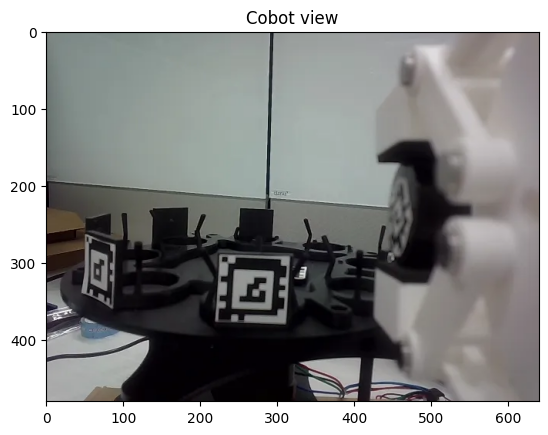

Found 2 tags

Tag ID: 0
  Center: [171.29774539  70.05659718]
  Corners: [[153.85586548  59.59589386]
 [143.07151794  80.73452759]
 [189.94595337  81.24079132]
 [198.08035278  59.92478561]]
  Translation (x, y, z): [-0.04362554 -0.04730404  0.14346474]
  Distance from camera: 15.72 centimeters
  Roll: -1.21°, Pitch: 45.33°, Yaw: 89.38°

Tag ID: 1
  Center: [145.10362364 268.38379319]
  Corners: [[120.80589294 240.79142761]
 [119.38231659 292.26516724]
 [169.32197571 295.88601685]
 [171.50961304 243.86671448]]
  Translation (x, y, z): [-0.04444595  0.00836341  0.12463108]
  Distance from camera: 13.26 centimeters
  Roll: 4.79°, Pitch: -3.28°, Yaw: 93.13°


In [111]:
result = client.predict(
	user_id=USER_ID,
	api_name="/query_camera"
)
print(result)
display_result(result)

image_path = result[1]["value"]

import numpy as np

camera_params = np.load("camera_params.npy", allow_pickle=True).item()

detections = detect_apriltags(
    image_path,
    camera_matrix=camera_params['camera_matrix'],
    dist_coeffs=camera_params['dist_coeff'],
    tag_size_meters=0.013,
    families="tagStandard52h13",
    only_ID=False
)


In [ ]:
det = min(detections, key=lambda d: np.linalg.norm(d.pose_t))

pose_t = det.pose_t.flatten()        
pose_R = det.pose_R                   

offset_in_world = pose_R @ (GRIPPER_TOTAL_OFFSET_PLACEMENT / 1000.0) 
pose_t_corrected = pose_t + offset_in_world              
pose_t_corrected_mm = pose_t_corrected * 1000         

rx1, ry1, rz1 = R.from_matrix(pose_R).as_euler('xyz', degrees=False)  

x1, y1, z1 = pose_t_corrected_mm

print("Corrected position for gripper (mm):", pose_t_corrected_mm)
print("Euler angles (radians):", rx1, ry1, rz1)
print("Tag Z axis in camera frame:", pose_R[:, 2])

Corrected position for gripper (mm): [-16.38137856  14.51311792  44.11051762]
Euler angles (radians): 0.0836763316708481 -0.05717363297362188 1.625406873123964
Tag Z axis in camera frame: [ 0.08656224 -0.05229566  0.99487293]


Query cobot pose and compute object position using AprilTag and hand-eye calibration.

In [113]:
result = client.predict(
    user_id=USER_ID,
    api_name="/query_coords"
)
display_result(result)

queue status: Your turn! Time remaining: 17.31 seconds.
response json: {'success': True, 'coords': [-56.3, 122.1, 194.3, -94.12, -46.11, -64.82], 'command': 'query/coords'}


In [114]:
import json
import numpy as np

result_json = json.loads(result[0])
coords = result_json["coords"]  
x, y, z, rx, ry, rz = coords

rx_rad = np.radians(rx)
ry_rad = np.radians(ry)
rz_rad = np.radians(rz)

result_pose = convert(
    x, y, z,               
    rx_rad, ry_rad, rz_rad,  
    x1, y1, z1,               
    rx1, ry1, rz1           
)

position, rx_base, ry_base, rz_base = result_pose

print("Target pose in robot base frame:")
print("Position:", position)
print("Rotation (Euler angles in rad):", rx_base, ry_base, rz_base)

Target pose in robot base frame:
Position: [-30.31171568 179.29293621 173.2782511 ]
Rotation (Euler angles in rad): -1.498889445212013 0.8204373094946816 -1.1527736007852767


Move above the target slot to prepare for placement.

In [ ]:
x, y, z = position

z += 80

above_pose = ((x, y, z), rx_base, ry_base, rz_base)
move_to_pose(above_pose)

Sending coords (mm, deg): -30.31 179.29 253.28 -85.88 47.01 -66.05
queue status: Your turn! Time remaining: 11.12 seconds.
response json: {'success': True, 'command': 'control/coords'}


Descend to place the vial into the target slot.

In [ ]:
x, y, z = position

z += 20

above_pose = ((x, y, z), rx_base, ry_base, rz_base)
move_to_pose(above_pose)

Sending coords (mm, deg): -30.31 179.29 203.28 -85.88 47.01 -66.05
queue status: Your turn! Time remaining: 6.48 seconds.
response json: {'success': True, 'command': 'control/coords'}


Open gripper

In [128]:
result = client.predict(
	user_id=USER_ID,
	gripper_value = 90,
	movement_speed = 100,
	api_name="/control_gripper"
)
display_result(result)

queue status: Your turn! Time remaining: 120.00 seconds.
response json: {'success': True, 'command': 'control/gripper'}


Finally, move the cobot to the home palce

In [ ]:
x, y, z = position

z += 60

above_pose = ((x, y, z), rx_base, ry_base, rz_base)
move_to_pose(above_pose)

result = client.predict(
    user_id=USER_ID,
    **DEFAULT_DETECTION_POSE, 
    api_name="/control_angles"
)
display_result(result)

result = client.predict(
    user_id=USER_ID,
    **INITIAL_HOME_POSE, 
    api_name="/control_angles"
)
display_result(result)